# Imports

In [ ]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


# Data

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from keras.models import Sequential
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir("/content/drive/MyDrive/Text_Mining_Project_Amazon/")
!pwd

/content/drive/MyDrive/Text_Mining_Project_Amazon


In [ ]:
#we use the second text processed file
df = pd.read_csv("AmazonFinal_classification.csv")

we now prepare the data for the binary classification task, splitting as explained into the report between Positive and Negative.

In [ ]:
conditions = [
    (df['Score'] <= 3),
    (df['Score'] >= 4)
    ]
values = [ 'Negative' , 'Positive']
df['Polarity'] = np.select(conditions, values)

In [ ]:
df.head()

,Text,Summary,Score,Time,HelpfulnessNumerator,Polarity
0,I bought several Vitality canned dog food prod...,Good Quality Dog Food,5,1303862400,1,Positive
1,Product arrived labeled Jumbo Salted Peanutsth...,Not as Advertised,1,1346976000,0,Negative
2,This confection around centuries It light pill...,"""Delight"" says it all",4,1219017600,1,Positive
3,If looking secret ingredient Robitussin I beli...,Cough Medicine,2,1307923200,3,Negative
4,Great taffy great price There wide assortment ...,Great taffy,5,1350777600,0,Positive


In [ ]:
df.shape

(393735, 6)

In [ ]:
df.Polarity.unique()

array(['Positive', 'Negative'], dtype=object)

In [ ]:
classes = df.Polarity.unique()
counts = []

for i in classes:
  count = len(df[df.Polarity==i])
  counts.append(count)

plt.bar(['positive', 'negative'], counts)
plt.show()

In [ ]:
for i in classes:
  count = len(df[df.Polarity==i])
  print(count)

306887
86848


In [ ]:
#df.loc[df['Polarity'] == 'positive']

positive = df.loc[df['Polarity'] == 'Positive']
negative = df.loc[df['Polarity'] == 'Negative']

In [ ]:
positive = positive.sample(n = 86848)

In [ ]:
frames = [positive, negative]
result = pd.concat(frames)

In [ ]:
df = result
df.columns

Index(['Text', 'Summary', 'Score', 'Time', 'HelpfulnessNumerator', 'Polarity'], dtype='object')

In [ ]:
df.shape

(173696, 6)

In [ ]:
from datetime import datetime
df['Time_date'] = [datetime.fromtimestamp(x) for x in df['Time']]

In [ ]:
df['timestamp'] = pd.to_datetime(df['Time'])

In [ ]:
df['day_name'] = df['Time_date'].dt.dayofweek

In [ ]:
#f['datehour'] = df['timestamp'].dt.hour

In [ ]:
df.HelpfulnessNumerator.mean()

1.8991686624907884

In [ ]:
conditions = [
    (df['day_name'] == 0),
    (df['day_name'] == 1),
     (df['day_name'] == 2), 
     (df['day_name'] == 3), 
     (df['day_name'] == 4),
      (df['day_name'] == 5),
       (df['day_name'] == 6)
    ]

values = [ 'Mon' , 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

df['wkd'] = np.select(conditions, values)

In [ ]:
df_backup = df

### Weekday influence on your reviews sentiment

Assumption - on some days you are more likely to be mad/happy about a product

Let's compare the counts first.

In [ ]:
#df['wkd'] = [i[0:3] for i in df['date']]

In [ ]:
negativeCount = df[df.Polarity == 'Positive']['wkd'].value_counts()
positiveCount = df[df.Polarity == 'Negative']['wkd'].value_counts()  

In [ ]:
negativeCount

Thu    13297
Mon    13254
Tue    13143
Wed    13036
Fri    11785
Sun    11351
Sat    10982
Name: wkd, dtype: int64

In [ ]:
countDf = pd.DataFrame()
countDf['wkd'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
countDf['negative'] = [negativeCount[i] for i in countDf['wkd']]
countDf['positive'] = [positiveCount[i] for i in countDf['wkd']]

countDfdf.background_gradient()

,wkd,negative,positive
0,Mon,13254,12907
1,Tue,13143,13136
2,Wed,13036,13814
3,Thu,13297,14067
4,Fri,11785,12231
5,Sat,10982,10473
6,Sun,11351,10220


In [ ]:
df.columns

Index(['Text', 'Summary', 'Score', 'Time', 'HelpfulnessNumerator', 'Polarity',
       'Time_date', 'timestamp', 'day_name', 'wkd'],
      dtype='object')

In [ ]:
for i in df.wkd.unique():
  df[i] = [int(i==l) for l in df.wkd]
df.head()

,Text,Summary,Score,Time,HelpfulnessNumerator,Polarity,Time_date,timestamp,day_name,wkd,Fri,Wed,Sun,Mon,Thu,Sat,Tue
229746,I tea drinker since I young I love tea The Jas...,"Great tea, buy it",5,1188518400,1,Positive,2007-08-31,1970-01-01 00:00:01.188518400,4,Fri,1,0,0,0,0,0,0
378219,I using product months I fighting Gall Bladder...,Satisfies my coffee fix with benefits!,5,1251849600,25,Positive,2009-09-02,1970-01-01 00:00:01.251849600,2,Wed,0,1,0,0,0,0,0
342782,add little water poof seaweed eati like mix ri...,convenient and tasty,5,1298764800,1,Positive,2011-02-27,1970-01-01 00:00:01.298764800,6,Sun,0,0,1,0,0,0,0
286355,I buying bulk tea years quality flavor tea exc...,Excellent,5,1232236800,3,Positive,2009-01-18,1970-01-01 00:00:01.232236800,6,Sun,0,0,1,0,0,0,0
372300,I regular customer Gevalia yrs I receive shipm...,Gevalia has the best coffee!,4,1302998400,0,Positive,2011-04-17,1970-01-01 00:00:01.302998400,6,Sun,0,0,1,0,0,0,0


In [ ]:
conditions = [
    (df['Polarity'] == 'Positive'),
    (df['Polarity'] == 'Negative')
    ]

values = [ 1, 0]

df['target'] = np.select(conditions, values)

In [ ]:
df[['target','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].corr()['target']

df_beauty = df[['target','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].corr()['target']
df_beauty.background_gradient()

target    1.000000
Mon       0.005585
Tue       0.000112
Wed      -0.012390
Thu      -0.012168
Fri      -0.007439
Sat       0.008906
Sun       0.019744
Name: target, dtype: float64

From correlations we see that middel week has something.

### HelpfulnessNumerator impact on reviews sentiment

In [ ]:
df.groupby(['HelpfulnessNumerator']).count()

,Text,Summary,Score,Time,Polarity,Time_date,timestamp,day_name,wkd,Fri,Wed,Sun,Mon,Thu,Sat,Tue,target
HelpfulnessNumerator,,,,,,,,,,,,,,,,,
0,88374,88373,88374,88374,88374,88374,88374,88374,88374,88374,88374,88374,88374,88374,88374,88374,88374
1,35687,35685,35687,35687,35687,35687,35687,35687,35687,35687,35687,35687,35687,35687,35687,35687,35687
2,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250,17250
3,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644,9644
4,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847,5847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
538,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
580,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [ ]:
# 1 very usefull, 2 usefull,  3 medium ,4 not so usefull, 5 unusefull 

In [ ]:
conditions = [
    (df['HelpfulnessNumerator'] <= 5),
    (df['HelpfulnessNumerator'] <= 70) & (df['HelpfulnessNumerator'] > 5 ),
     (df['HelpfulnessNumerator'] <= 110) & (df['HelpfulnessNumerator'] > 70), 
     (df['HelpfulnessNumerator'] <= 130) & (df['HelpfulnessNumerator'] > 110), 
     (df['HelpfulnessNumerator'] > 130)
    ]

values = [ 5, 4, 3, 2, 1 ]

df['Help'] = np.select(conditions, values)

In [ ]:
df.Help.unique()

array([5, 4, 3, 1, 2])

In [ ]:
df

,Text,Summary,Score,Time,HelpfulnessNumerator,Polarity,Time_date,timestamp,day_name,wkd,Sat,Wed,Thu,Fri,Sun,Tue,Mon,target,Help
303299,I love variety flavors tea great I always box ...,excellent choice,5,1313798400,1,Positive,2011-08-20,1970-01-01 00:00:01.313798400,5,Sat,1,0,0,0,0,0,0,1,5
52494,If feed best friend Innova Small Bite Innova D...,A Good Supplemental Treat to Innova Small Bit...,5,1335312000,0,Positive,2012-04-25,1970-01-01 00:00:01.335312000,2,Wed,0,1,0,0,0,0,0,1,5
206669,The Dentastix work really well keeping dogs br...,Works well!,5,1348099200,0,Positive,2012-09-20,1970-01-01 00:00:01.348099200,3,Thu,0,0,1,0,0,0,0,1,5
258582,From everything I tell cacoa really good body ...,The Student,5,1218153600,0,Positive,2008-08-08,1970-01-01 00:00:01.218153600,4,Fri,0,0,0,1,0,0,0,1,5
176014,These really tasty fact Because made fruit nut...,Excellent Snack.,4,1320537600,0,Positive,2011-11-06,1970-01-01 00:00:01.320537600,6,Sun,0,0,0,0,1,0,0,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393714,I bought soup today local grocer brought back ...,Tastes horrible!,1,1311638400,0,Negative,2011-07-26,1970-01-01 00:00:01.311638400,1,Tue,0,0,0,0,0,1,0,0,5
393715,This soup mostly broth Although kick also swee...,Not so good,2,1306368000,0,Negative,2011-05-26,1970-01-01 00:00:01.306368000,3,Thu,0,0,1,0,0,0,0,0,5
393716,It mostly broth advertised cup vegetables Howe...,Where's the tortellini?,2,1285718400,0,Negative,2010-09-29,1970-01-01 00:00:01.285718400,2,Wed,0,1,0,0,0,0,0,0,5
393727,I ordered months back great latest batch terri...,Mixed wrong,2,1328918400,0,Negative,2012-02-11,1970-01-01 00:00:01.328918400,5,Sat,1,0,0,0,0,0,0,0,5


In [ ]:
hourCount = pd.DataFrame()

hourCount['Help'] = df['Help'].unique()
countDict = {}

for i in df.target.unique():
  countDict[i] = df[df.target == i]['Help'].value_counts()

In [ ]:
for i in countDict:
  if i == 0:
    sentiment = 'negative'
  else:
    sentiment = 'positive'
  hourCount[sentiment] = [countDict[i][h] for h in hourCount['Help']]

hourCount.sort_values(by=['Help'], inplace=True)
hourCount.reset_index(drop=True, inplace=True)
hourCount

,Help,positive,negative
0,1,22,52
1,2,13,10
2,3,45,73
3,4,5351,7371
4,5,81417,79342


Too much lines, it's hard to read. Let's make a plot

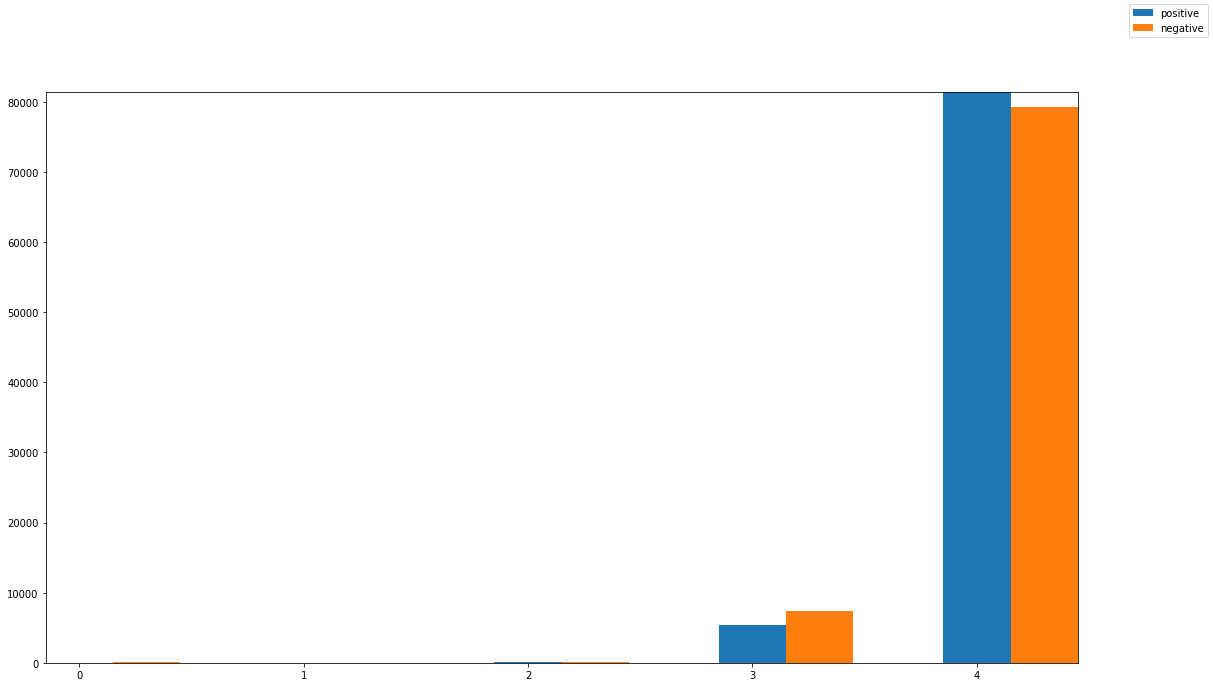

In [ ]:
w = 0.3
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for count, i in enumerate(hourCount.columns[1:]):
  ax.bar(x=hourCount.index+count*w, width=w, height=hourCount[i])

ax.autoscale(tight=True)
fig.set_size_inches(18.5, 10.5)
fig.legend(hourCount.columns[1:])
fig.show()

In [ ]:
for i in df.Help.unique():
  df[i] = [int(i==l) for l in df.Help]

In [ ]:
cols = [i for i in hourCount.Help]
cols.append('target')

df[cols].corr()['target']

1        -0.008370
2         0.001501
3        -0.006187
4        -0.044637
5         0.045500
target    1.000000
Name: target, dtype: float64

There's nothing significant, helpfulness is too polarized

## Train/test split

we can take a sample of 10% or 5% (for gpu constraint) and then split that into 80% for training and 20% for testing.

In [ ]:
df.shape

(173696, 24)

In [ ]:
sample_size = int(len(df)*0.05) #0.10
sampleDf = df.sample(sample_size, random_state=23)
wkd = sampleDf.wkd.values
x = sampleDf.Text.values
y = sampleDf.Polarity.values
wkd_train, wkd_test, x_train, x_test, y_train, y_test = train_test_split(wkd, x, y, test_size=0.20, random_state=32)

## Label Encoding

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

We might want to use encoding for later. For that we can save enconding map.

In [ ]:
encoder_fname = 'text_classes_mod.npy'
my_wd = '/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

To load it when you'll use this in testing just use the below cell.

In [ ]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

Lastly we need to add two additional tokens: Classification and Seperation. We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

## Prep inputs

First let's set the max sequence lenght as we did in simple NN.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

text = tf.ragged.constant([encode_names(n, tokenizer) for n in x_train])
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*text.shape[0]
input_word_ids = tf.concat([cls, text], axis=-1)

lens = [len(i) for i in input_word_ids]

In [ ]:
max_seq_length = 384
print('Max length is:', max_seq_length)

Max length is: 384


In [ ]:
#max_seq_length = 512
print('Max length is:', max_seq_length)

In [ ]:
featureEncoder = LabelEncoder()
featureEncoder.fit(wkd)
encoded_wkd_train = featureEncoder.transform(wkd_train)
encoded_wkd_test = featureEncoder.transform(wkd_test)
dummy_wkd_train = np_utils.to_categorical(encoded_wkd_train)
dummy_wkd_test = np_utils.to_categorical(encoded_wkd_test)

In [ ]:
featureEncoder_fname = 'text_wkd.npy'
my_wd = '/'
np.save(os.path.join(my_wd, featureEncoder_fname) , featureEncoder.classes_)

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list,
                tokenizer, 
                new_feature, 
                new_feature_class_count, 
                max_seq_length):  
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))
  feature = tf.ragged.constant(new_feature).to_tensor(shape=(None, new_feature_class_count)) 

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids,
      'additional_feature': feature} 

  return inputs

In [ ]:
feature_class_count = len(df.wkd.unique())
X_train = bert_encode(x_train, tokenizer, dummy_wkd_train, feature_class_count, max_seq_length)
X_test = bert_encode(x_test, tokenizer, dummy_wkd_test, feature_class_count, max_seq_length)

# BERT MODEL

## Initial training

In [ ]:
num_class = len(encoder.classes_) 
max_seq_length = max_seq_length  

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
feature_input = tf.keras.layers.Input(shape=(feature_class_count,), 
                                      dtype=tf.float32, 
                                      name="additional_feature")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])    

output = tf.keras.layers.concatenate([pooled_output, feature_input], name='pooled_with_additional')  
output = tf.keras.layers.Dropout(rate=0.1)(output)  

 

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids,
        'additional_feature': feature_input  
        },
        outputs=output)

Our model.

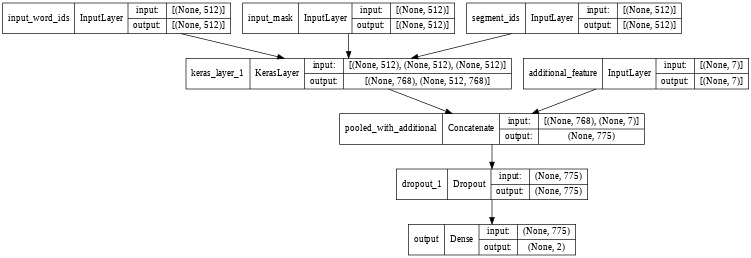

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Set up the training parameters.

In [ ]:
epochs = 3
batch_size = 6  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.05 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Set up a history to check our model performance afterwards.

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

## Model saving for later use

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'text_BERT_wWKD'  # [NEW]
my_wd = '/content/drive/MyDrive/Text_Mining_Project_Amazon/TextClassificationRepo/Bert_models/'

model.save(os.path.join(my_wd, model_fname))

### Validate saved model

In [ ]:
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

In [ ]:
new_model.summary()

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
tokenizedText = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedText:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

# Test

In [ ]:
encoder_fname = 'text_classes_mod.npy'
my_wd = '/content/drive/MyDrive/Text_Mining_Project_Amazon/TextClassificationRepo/Bert_models/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

In [ ]:
encoder.classes_

In [ ]:
encoder_fname = 'text_wkd.npy'
my_wd = '/content/drive/MyDrive/Text_Mining_Project_Amazon/TextClassificationRepo/Bert_models/'

featureEncoderSaved = LabelEncoder()
featureEncoderSaved.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

In [ ]:
featureEncoderSaved.classes_

In [ ]:
model_fname = 'text_BERT_wWKD'
my_wd = '/content/drive/MyDrive/Text_Mining_Project_Amazon/TextClassificationRepo/Bert_models/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
text = ["Amazing food very good"]
wkd = ['Mon']

dummy_wkd = np_utils.to_categorical(featureEncoderSaved.transform(np.array(wkd)))  # encodes weekday

inputs = bert_encode(string_list=list(text),
                      tokenizer=tokenizerSaved,
                      new_feature=dummy_wkd,
                      new_feature_class_count=7,
                      max_seq_length=512)

In [ ]:
prediction = new_model.predict(inputs)
print(prediction)
print('Text is', 'positive' if encoder.classes_[np.argmax(prediction)]=='Positive' else 'negative')